In [25]:
import pandas as pd
import nltk 
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text
from matplotlib import pyplot as plt
import seaborn as sns
import transformers, torch
from tqdm import notebook


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evgeniy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

dataset source https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

# Feature extraction

In [2]:
train_tweets = pd.read_csv('/Users/evgeniy/Downloads/archive-3/train.csv', usecols=['label', 'tweet'])
test_tweets = pd.read_csv('/Users/evgeniy/Downloads/archive-3/test.csv')

In [3]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [4]:
test_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
train_tweets.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [7]:
train_tweets['cleared_tweets'] = train_tweets['tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x))

In [8]:
train_tweets['cleared_tweets'] = train_tweets['cleared_tweets'].apply(lambda x: ' '.join(x.split()))

# Classes balance

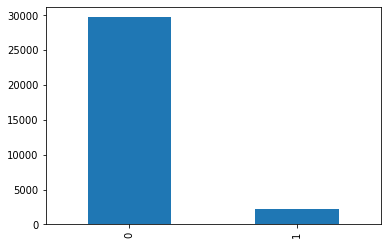

In [9]:
train_tweets['label'].value_counts().plot(kind='bar');

In [10]:
print('Minority class rate: {:.2%}'.format(
    train_tweets['label'].sum() / train_tweets.shape[0])
     )

Minority class rate: 7.01%


# Vectorizing

In [11]:
tfidf_vect = TfidfVectorizer(stop_words=stop_words, max_features=10000, ngram_range=(3, 3))
sparsed = tfidf_vect.fit_transform(train_tweets['cleared_tweets'])

tfidf = sparsed.toarray()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(sparsed, 
                                                    train_tweets['label'], 
                                                    test_size=.25,
                                                    random_state=42)

# Models

## Bayes 

In [97]:
def test_model(model, X_train=X_train, X_test=X_test,
              y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    preds_proba = model.predict_proba(X_test)
    preds = model.predict(X_test)
    print('ROC AUC: ', roc_auc_score(y_test, preds_proba[: , 1]))
    print('Confusion matrix:')
    display(pd.DataFrame(confusion_matrix(y_test, preds)))
    fpr, tpr, _ = roc_curve(y_test, preds_proba[: , 1])
    plt.plot(fpr, tpr, label='model curve')
    plt.plot([0, 1], [0, 1], '-', label='random')
    plt.legend();

ROC AUC:  0.671023481112474
Confusion matrix:


,0,1
0,7082,350
1,382,177


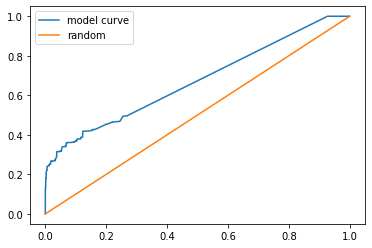

In [98]:
test_model(model)

ROC AUC:  0.7154532640363866
Confusion matrix:


,0,1
0,7432,0
1,458,101


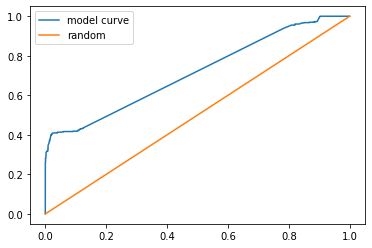

In [102]:
model = MultinomialNB()
test_model(model)

## Dense net 

In [112]:
model = Sequential()
model.add(Dense(1024, input_dim=10000, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [114]:
model.fit(X_train.toarray(), y_train, validation_data=(X_test.toarray(), y_test),
         epochs=5, verbose=2)

Epoch 1/5
750/750 - 52s - loss: 0.2128 - auc: 0.6980 - val_loss: 0.1817 - val_auc: 0.7620
Epoch 2/5
750/750 - 53s - loss: 0.1596 - auc: 0.8000 - val_loss: 0.1883 - val_auc: 0.7610
Epoch 3/5
750/750 - 53s - loss: 0.1545 - auc: 0.8114 - val_loss: 0.1861 - val_auc: 0.7592
Epoch 4/5
750/750 - 53s - loss: 0.1527 - auc: 0.8187 - val_loss: 0.1863 - val_auc: 0.7549
Epoch 5/5
750/750 - 53s - loss: 0.1514 - auc: 0.8160 - val_loss: 0.1934 - val_auc: 0.7566


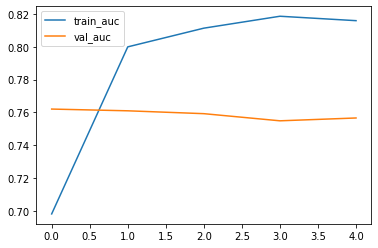

In [122]:
plt.plot(range(0, 5), model.history.history['auc'], label='train_auc')
plt.plot(range(0, 5), model.history.history['val_auc'], label='val_auc')
plt.legend();

In [124]:
model = Sequential()
model.add(Dense(1024, input_dim=10000, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [125]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [126]:
model.fit(X_train.toarray(), y_train, validation_data=(X_test.toarray(), y_test),
         epochs=5, verbose=2)

Epoch 1/5
750/750 - 54s - loss: 0.2183 - auc: 0.6824 - val_loss: 0.1818 - val_auc: 0.7655
Epoch 2/5
750/750 - 53s - loss: 0.1641 - auc: 0.7979 - val_loss: 0.1793 - val_auc: 0.7638
Epoch 3/5
750/750 - 53s - loss: 0.1567 - auc: 0.8125 - val_loss: 0.1798 - val_auc: 0.7635
Epoch 4/5
750/750 - 53s - loss: 0.1551 - auc: 0.8134 - val_loss: 0.1833 - val_auc: 0.7627
Epoch 5/5
750/750 - 53s - loss: 0.1543 - auc: 0.8111 - val_loss: 0.1846 - val_auc: 0.7623


## Embedings

In [134]:
model = Sequential()
model.add(Embedding(64, 300, input_length=10000))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [135]:
model.fit(X_train.toarray(), y_train, validation_data=(X_test.toarray(), y_test),
         epochs=5, verbose=2)

Epoch 1/5
750/750 - 301s - loss: 0.3693 - auc: 0.4931 - val_loss: 0.3288 - val_auc: 0.5221
Epoch 2/5
750/750 - 290s - loss: 0.2626 - auc: 0.5208 - val_loss: 0.2495 - val_auc: 0.5413
Epoch 3/5
750/750 - 294s - loss: 0.2512 - auc: 0.5596 - val_loss: 0.2874 - val_auc: 0.5418
Epoch 4/5
750/750 - 33161s - loss: 0.2479 - auc: 0.5731 - val_loss: 0.2509 - val_auc: 0.5421
Epoch 5/5
750/750 - 289s - loss: 1.1735 - auc: 0.5447 - val_loss: 0.2563 - val_auc: 0.5420


In [14]:
train_tweets

,label,tweet,cleared_tweets
0,0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is so ...
1,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can t use c...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,0,factsguide: society now #motivation,factsguide society now motivation
...,...,...,...
31957,0,ate @user isz that youuu?ðððððð...,ate user isz that youuu
31958,0,to see nina turner on the airwaves trying to...,to see nina turner on the airwaves trying to w...
31959,0,listening to sad songs on a monday morning otw...,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,...",user sikh temple vandalised in in calgary wso ...


## Bert

In [15]:
tokenizer = transformers.BertTokenizer(vocab_file='/Users/evgeniy/Downloads/rubert_cased_L-12_H-768_A-12_pt/vocab.txt')
tokenized = train_tweets['cleared_tweets'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [20]:
maxlen = len(max(tokenized, key=len))
padded = np.array([i + [0] * (maxlen - len(i)) for i in tokenized])
attention_mask = np.where(padded != 0, 1, 0)

In [23]:
config = transformers.BertConfig.from_json_file('/Users/evgeniy/Downloads/rubert_cased_L-12_H-768_A-12_pt/bert_config.json')
model = transformers.BertModel.from_pretrained('/Users/evgeniy/Downloads/rubert_cased_L-12_H-768_A-12_pt/pytorch_model.bin', config=config)

Some weights of the model checkpoint at /Users/evgeniy/Downloads/rubert_cased_L-12_H-768_A-12_pt/pytorch_model.bin were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
batch_size = 100
embedings = []

In [28]:
for i in notebook.tqdm(range(train_tweets.shape[0]//batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    with torch.no_grad():
        batch_embedings = model(batch, attention_batch)
    embedings.append(batch_embedings[0][:,0,:].numpy())

  0%|          | 0/319 [00:00<?, ?it/s]

In [46]:
features = np.concatenate(embedings)
labels = train_tweets.loc[:31899, 'label']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42, test_size=.25)

In [49]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=features.shape[1]))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [50]:
model.fit(X_train, y_train,
         validation_data=(X_test, y_test),
         epochs=5, verbose=2)

Epoch 1/5
748/748 - 4s - loss: 0.1930 - auc: 0.8379 - val_loss: 0.1785 - val_auc: 0.8873
Epoch 2/5
748/748 - 3s - loss: 0.1760 - auc: 0.8692 - val_loss: 0.1738 - val_auc: 0.8851
Epoch 3/5
748/748 - 3s - loss: 0.1671 - auc: 0.8853 - val_loss: 0.1720 - val_auc: 0.8963
Epoch 4/5
748/748 - 3s - loss: 0.1608 - auc: 0.8947 - val_loss: 0.1728 - val_auc: 0.8990
Epoch 5/5
748/748 - 3s - loss: 0.1560 - auc: 0.9010 - val_loss: 0.1690 - val_auc: 0.8933


In [51]:
model.fit(X_train, y_train,
         validation_data=(X_test, y_test),
         epochs=15, verbose=2)

Epoch 1/15
748/748 - 3s - loss: 0.1476 - auc: 0.9130 - val_loss: 0.1608 - val_auc: 0.9042
Epoch 2/15
748/748 - 3s - loss: 0.1407 - auc: 0.9220 - val_loss: 0.1774 - val_auc: 0.8987
Epoch 3/15
748/748 - 3s - loss: 0.1329 - auc: 0.9304 - val_loss: 0.1824 - val_auc: 0.9067
Epoch 4/15
748/748 - 3s - loss: 0.1279 - auc: 0.9366 - val_loss: 0.1669 - val_auc: 0.9055
Epoch 5/15
748/748 - 3s - loss: 0.1185 - auc: 0.9471 - val_loss: 0.1715 - val_auc: 0.8982
Epoch 6/15
748/748 - 3s - loss: 0.1098 - auc: 0.9539 - val_loss: 0.1813 - val_auc: 0.8940
Epoch 7/15
748/748 - 3s - loss: 0.1040 - auc: 0.9597 - val_loss: 0.1818 - val_auc: 0.8901
Epoch 8/15
748/748 - 3s - loss: 0.0941 - auc: 0.9670 - val_loss: 0.1788 - val_auc: 0.8950
Epoch 9/15
748/748 - 3s - loss: 0.0872 - auc: 0.9718 - val_loss: 0.1771 - val_auc: 0.9031
Epoch 10/15
748/748 - 3s - loss: 0.0806 - auc: 0.9753 - val_loss: 0.2181 - val_auc: 0.8632
Epoch 11/15
748/748 - 3s - loss: 0.0735 - auc: 0.9798 - val_loss: 0.1910 - val_auc: 0.8931
Epoch 12

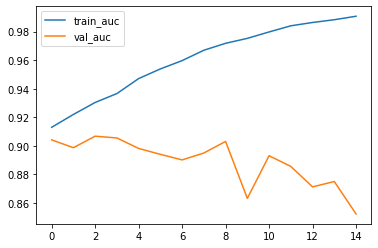

In [53]:
plt.plot(range(0, 15), model.history.history['auc'], label='train_auc')
plt.plot(range(0, 15), model.history.history['val_auc'], label='val_auc')
plt.legend();

In [54]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=features.shape[1]))
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

In [56]:
model.fit(X_train, y_train,
         validation_data=(X_test, y_test),
         epochs=50, verbose=2)

Epoch 1/50
748/748 - 3s - loss: 0.1403 - auc: 0.9234 - val_loss: 0.1634 - val_auc: 0.9023
Epoch 2/50
748/748 - 4s - loss: 0.1406 - auc: 0.9233 - val_loss: 0.1626 - val_auc: 0.9046
Epoch 3/50
748/748 - 3s - loss: 0.1375 - auc: 0.9233 - val_loss: 0.1630 - val_auc: 0.9056
Epoch 4/50
748/748 - 3s - loss: 0.1334 - auc: 0.9295 - val_loss: 0.1642 - val_auc: 0.9029
Epoch 5/50
748/748 - 3s - loss: 0.1325 - auc: 0.9308 - val_loss: 0.1679 - val_auc: 0.9025
Epoch 6/50
748/748 - 3s - loss: 0.1293 - auc: 0.9343 - val_loss: 0.1671 - val_auc: 0.9017
Epoch 7/50
748/748 - 3s - loss: 0.1262 - auc: 0.9371 - val_loss: 0.1637 - val_auc: 0.9040
Epoch 8/50
748/748 - 3s - loss: 0.1261 - auc: 0.9386 - val_loss: 0.1673 - val_auc: 0.9018
Epoch 9/50
748/748 - 3s - loss: 0.1223 - auc: 0.9416 - val_loss: 0.1648 - val_auc: 0.9032
Epoch 10/50
748/748 - 3s - loss: 0.1205 - auc: 0.9428 - val_loss: 0.1785 - val_auc: 0.8936
Epoch 11/50
748/748 - 3s - loss: 0.1174 - auc: 0.9456 - val_loss: 0.1726 - val_auc: 0.9012
Epoch 12

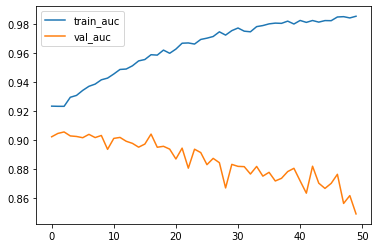

In [57]:
plt.plot(range(0, 50), model.history.history['auc'], label='train_auc')
plt.plot(range(0, 50), model.history.history['val_auc'], label='val_auc')
plt.legend();

# Lemming

In [75]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /Users/evgeniy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [73]:
train_tweets['lemmas'] = train_tweets['cleared_tweets'].apply(
    lambda x: ' '.join(
        [lemmatizer.lemmatize(i) for i in x.split()]
    )
)

In [78]:
tokenizer = text.Tokenizer()

In [87]:
tokenizer.fit_on_texts(train_tweets['lemmas'].values.astype('U'))

In [90]:
tokens = tokenizer.texts_to_matrix(train_tweets['lemmas'].values.astype('U'))

In [94]:
X_train, X_test, y_train, y_test = train_test_split(tokens, train_tweets['label'],
                                                   random_state=42, test_size=.25)

In [100]:
model = Sequential()
model.add(Dense(1024, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=['AUC'], optimizer='adam')

In [101]:
model.fit(X_train, y_train, validation_data=(X_test, y_test),
         epochs=5, verbose=2)

Epoch 1/5
750/750 - 127s - loss: 0.1619 - auc: 0.8946 - val_loss: 0.1396 - val_auc: 0.9273
Epoch 2/5
750/750 - 123s - loss: 0.0426 - auc: 0.9923 - val_loss: 0.1530 - val_auc: 0.9230
Epoch 3/5
750/750 - 122s - loss: 0.0075 - auc: 0.9986 - val_loss: 0.2921 - val_auc: 0.8766
Epoch 4/5
750/750 - 122s - loss: 0.0027 - auc: 0.9997 - val_loss: 0.3980 - val_auc: 0.8560
Epoch 5/5
750/750 - 121s - loss: 7.9005e-04 - auc: 1.0000 - val_loss: 0.4980 - val_auc: 0.8330


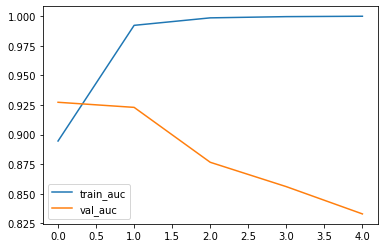

In [102]:
plt.plot(range(0, 5), model.history.history['auc'], label='train_auc')
plt.plot(range(0, 5), model.history.history['val_auc'], label='val_auc')
plt.legend();